In [3]:
import scanpy as sc
import pandas as pd
import numpy as np

#import math #計算combinations
import random #做隨機抽樣分布

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import norm


from tqdm import tqdm

In [4]:
from package.cell_dispersion_function import create_distance_matrix

In [5]:
healthy = sc.read_h5ad("GSE165080_healthy.h5ad")

In [6]:
healthy.obs

,Age,Gender,BioSample,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden,cell_type_1,cell_type_2,cell_type_3
AAACCTGAGAGTTGGC-1,34,female,SAMN17379694,3734,3734,11946.0,529.0,4.428260,2,Mono,CD14 Mono,CD14 Mono
AAACCTGAGGGCTTGA-1,34,female,SAMN17379694,2001,2001,4745.0,338.0,7.123288,20,other T,gdT,CD8 TEM_6
AAACCTGCAAGCTGTT-1,34,female,SAMN17379694,2471,2471,7979.0,384.0,4.812633,5,CD8 T,CD8 Naive,CD8 Naive_2
AAACCTGCAATAAGCA-1,34,female,SAMN17379694,1487,1487,2865.0,371.0,12.949389,9,NK,NK,NK_2
AAACCTGCAATGTAAG-1,34,female,SAMN17379694,2423,2423,6729.0,550.0,8.173576,9,CD8 T,CD8 TCM,CD8 TCM_3
...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAAGCTGAACG-1,39,male,SAMN17379591,1054,1054,2108.0,136.0,6.451612,4,CD4 T,CD4 TCM,CD4 TCM_1
TTTGTCACACGGTAGA-1,39,male,SAMN17379591,757,757,1257.0,199.0,15.831344,16,CD8 T,NK,NK_1
TTTGTCACAGGACGTA-1,39,male,SAMN17379591,1882,1882,5846.0,178.0,3.044817,4,CD4 T,CD4 TCM,CD4 TCM_1
TTTGTCAGTCCAGTGC-1,39,male,SAMN17379591,1407,1407,3106.0,194.0,6.245975,15,CD8 T,CD8 TEM,CD8 TEM_6


C:\ProgramData\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


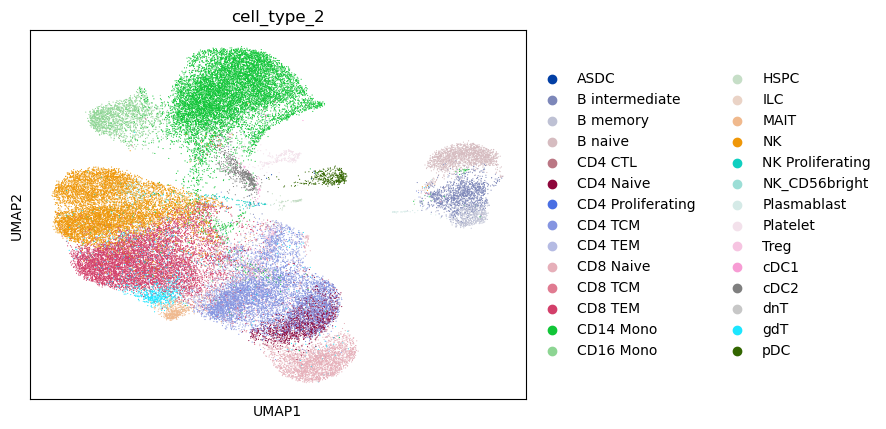

In [7]:
sc.pl.umap(healthy, color = "cell_type_2")

# 開始處理cell dispersion

我需要先把每個人的部分個別提取出來，最後再將每個人的NK提取出來做cell dispersion

In [8]:
healthy.obs.cell_type_2

AAACCTGAGAGTTGGC-1    CD14 Mono
AAACCTGAGGGCTTGA-1          gdT
AAACCTGCAAGCTGTT-1    CD8 Naive
AAACCTGCAATAAGCA-1           NK
AAACCTGCAATGTAAG-1      CD8 TCM
                        ...    
TTTGTCAAGCTGAACG-1      CD4 TCM
TTTGTCACACGGTAGA-1           NK
TTTGTCACAGGACGTA-1      CD4 TCM
TTTGTCAGTCCAGTGC-1      CD8 TEM
TTTGTCATCCTGTACC-1    CD4 Naive
Name: cell_type_2, Length: 46160, dtype: category
Categories (28, object): ['ASDC', 'B intermediate', 'B memory', 'B naive', ..., 'cDC2', 'dnT', 'gdT', 'pDC']

In [9]:
BioSample = healthy.obs.BioSample

personal = {}
personal_df = {}
for i in BioSample:
    if i not in personal:
        personal[i] = healthy[healthy.obs["BioSample"] == i, :]
        personal_df[i] = healthy[healthy.obs["BioSample"] == i, :]
len(personal)

11

In [10]:
sorted_personal = dict(sorted(personal.items(), key=lambda x: x[1].obs.Age[0]))
age = []
for i in sorted_personal:
    age.append(sorted_personal[i].obs.Age[0])
age

[34, 34, 35, 39, 39, 40, 44, 50, 51, 52, 56]

In [11]:
#personal["SAMN17379721"].obs.cell_type_l1

#NK_1 = personal["SAMN17379721"][personal["SAMN17379721"].obs["cell_type_l1"] == "NK", :]

# Cell Dispersion Calculate

In [12]:
# 將30~50個不同的cell放入新的dataframe中，以便後續進行計算
def renew_sampling_list(cell_type, minimum):
    # 隨機抽樣，抽取30~50個不同的cell之後要做cell dispersion的計算
    sampling = []
    for i in range(0, int(min(1/2*minimum,50))):
        # 挑出cell的位置
        cell = random.randrange(0, cell_type.n_obs)
        while cell in sampling:
            cell = random.randrange(0, cell_type.n_obs)
        sampling.append(cell)
    
    # 紀錄30~50個cell * gene的資料
    cell_dispersion = []
    # 先將 cell type 變成dataframe後，做 transpose 之後才能夠把挑選出來的 genes 放進去
    cell_type_transpose = pd.DataFrame(data = cell_type.X, columns = cell_type.var.index.values)
    # 做50次的隨機抽樣並且將結果
    for i in range(0, int(min(1/2*minimum, 50))):
        # 將dataframe塞進去新的list中
        cell_dispersion.append(cell_type_transpose.loc[sampling[i]])
    #將list轉成dataframe的格式
    cell_dispersion = np.array(cell_dispersion)
    
    return cell_dispersion

# 將某一個人的 cell type 提取出來做cell dispersion, 之後再拿其他人的去做比較 
# 要給numpy array的格式
def create_distance_matrix(data):
    # must be two dimension array, so need to change dataframe into array
    ncells = data.shape[0]
    
    index1 = np.concatenate(tuple(np.repeat(i, ncells) for i in range(0,ncells)), axis =None)
    index2 = np.tile(np.arange(0, ncells, 1), ncells)
    
    X = data[:, index1]
    Y = data[:, index2]
    
    out = np.sqrt(np.sum((X - Y) * (X - Y), axis = 0))
    distance_matrix = np.reshape(out, (ncells, ncells))
    
    return distance_matrix

# 計算離散程度，將n*n計算過後的matrix丟進來
def calculate_dispersion(distance):
    # np.triu只取上三角，其餘的都變成0
    dispersion = np.triu(distance).sum()/np.count_nonzero(np.triu(distance))
    return dispersion


# 將上面的所有的function合併成這個function執行
def Excute_all(sorted_personal, cell_type_name):# cell_type_name是字串的型態
    
    # 挑出最小值
    minimum = 50
    for i in sorted_personal:
        a = sorted_personal[i][sorted_personal[i].obs.cell_type_1 == cell_type_name, :].obs
        if len(a) < minimum:
            minimum = len(a)

    pbar = tqdm(total = len(personal))

    dispersion_personal = []
    mean = []
    std = []
    for i in sorted_personal:
        dispersion = []
        celltype = sorted_personal[i][sorted_personal[i].obs.cell_type_1 == cell_type_name, :]
        # 1000 times sampling
        for j in range(0,1000):
            # 取得sampling的dataframe
            cell_dispersion = renew_sampling_list(celltype, minimum)
            # 計算 cell * cell distance
            distance_matrix = create_distance_matrix(cell_dispersion)
            # 取得此次抽樣的dispersion
            dispersion.append(calculate_dispersion(distance_matrix))

        dispersion_personal.append(dispersion)
        mean.append(np.mean(dispersion))
        std.append(np.std(dispersion))
        pbar.update()

    pbar.close()
    
    return dispersion_personal, mean, std

# 結果畫圖

In [13]:
def scatter_plot(data, title, cell_type):
    # 獲取所有的顏色名稱
    #all_colors = list(mcolors.CSS4_COLORS.keys())

    # 隨機選擇11種顏色
    #colors = np.random.choice(all_colors, size=11)
    cmap = plt.get_cmap('nipy_spectral', len(personal))

    for i in range(len(personal)):
        # 假設 x 軸是數據的索引，y 軸是數據的值
        x = i
        y = data[i]

         # 使用 plt.scatter 方法來創建散點圖
        plt.scatter(x, y, color = cmap(i))

    # 給圖表加上標題和軸標籤
    plt.title(title)
    plt.xlabel('Sample')
    plt.ylabel('Value')

    # 添加圖例
    plt.legend(age, fontsize = 6)
    
    # 將圖形保存為PNG文件
    plt.savefig(f'Result_picture/Scatter_plot_{cell_type}.png', dpi=900)

    # 顯示圖表
    plt.show()
    

def errorbar(data, title, cell_type):
    # 獲取所有的顏色名稱
    #all_colors = list(mcolors.CSS4_COLORS.keys())

    # 隨機選擇11種顏色
    #colors = np.random.choice(all_colors, size=11)
    cmap = plt.get_cmap('nipy_spectral', len(personal))

    for i in range(11):
        # 假設 x 軸是數據的索引，y 軸是數據的值
        x = i
        y = data[i]

         # 使用 plt.scatter 方法來創建散點圖
        plt.errorbar(x, y, yerr = std_NK[i], color = cmap(i), fmt = 'o')

    # 計算趨勢線的參數
    z = np.polyfit(range(len(personal)), data, 1)
    # 創建一個多項式函數
    p = np.poly1d(z)
    # 在圖中添加趨勢線
    plt.plot(range(len(personal)), p(range(len(personal))), 'r--', label='Trend Line')
    
    
    # 給圖表加上標題和軸標籤
    plt.title(title)
    plt.xlabel('Sample')
    plt.ylabel('Value')

    # 添加圖例
    plt.legend(["Trand Line"] + age, fontsize = 6)
    
    # 將圖形保存為PNG文件
    plt.savefig(f'Result_picture/errorbar_{cell_type}.png', dpi=900)

    # 顯示圖表
    plt.show()

# Cell type 2

In [14]:
dispersion_personal_CD14_Mono, mean_CD14_Mono, std_CD14_Mono  = Excute_all(sorted_personal, "CD14 Mono")

  0%|          | 0/11 [00:00<?, ?it/s]

ValueError: need at least one array to concatenate

In [ ]:
count = 0
for i in sorted_personal:
    print(i)
    print("Age : ", age[count])
    print("Mean : ",mean_CD14_Mono[count])
    print("Standard Deviation : ", std_CD14_Mono[count], "\n")
    
    count += 1 

In [ ]:
scatter_plot(mean_CD14_Mono, "Cell Dispersion in CD14 Mono", "CD14 Mono")

In [ ]:
errorbar(mean_CD14_Mono, "Errorbar CD14 Mono", "CD14 Mono")

In [15]:
for i in range(0, len(mean_CD14_Mono)):
    x = np.arange(-4, 8, 0.001)
    y = norm.pdf(x, mean_CD14_Mono[i], std_CD14_Mono[i])
    plt.plot(x,y)
    
# 添加圖例
plt.legend(age, fontsize = 8)
# 添加標題和軸標籤
plt.title("CD14 Mono cell dispersion")
plt.xlabel('Different Sample')
plt.ylabel('Probability Density')


# 將圖形保存為PNG文件
plt.savefig('Result_picture/CD14 Mono cell dispersion.png', dpi=900)

NameError: name 'mean_CD14_Mono' is not defined

In [16]:
dispersion_personal_pDC, mean_pDC, std_pDC  = Excute_all(sorted_personal, "pDC")


  0%|          | 0/11 [00:00<?, ?it/s]

ValueError: need at least one array to concatenate

In [ ]:
scatter_plot(mean_pDC, "Cell Dispersion in pDC", "pDC")

In [17]:
errorbar(mean_pDC, "Errorbar pDC", "pDC")

NameError: name 'mean_pDC' is not defined

In [18]:
for i in range(0, len(mean_pDC)):
    x = np.arange(-4, 8, 0.001)
    y = norm.pdf(x, mean_pDC[i], std_pDC[i])
    plt.plot(x,y)
    
# 添加圖例
plt.legend(age, fontsize = 8)
# 添加標題和軸標籤
plt.title("CD14 Mono cell dispersion")
plt.xlabel('Different Sample')
plt.ylabel('Probability Density')


# 將圖形保存為PNG文件
plt.savefig('Result_picture/CD14 Mono cell dispersion.png', dpi=900)

NameError: name 'mean_pDC' is not defined

# Cell type 1

# NK cell dispersion

In [19]:
dispersion_personal_NK, mean_NK, std_NK = Excute_all(sorted_personal, "NK")

  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [03:15<00:00, 17.78s/it]


In [20]:
count = 0
for i in sorted_personal:
    print(i)
    print("Age : ", age[count])
    print("Mean : ",mean_NK[count])
    print("Standard Deviation : ", std_NK[count], "\n")
    
    count += 1 

SAMN17379694
Age :  34
Mean :  2.8193002673339844
Standard Deviation :  0.7666900591625458 

SAMN17379698
Age :  34
Mean :  2.9178333196004234
Standard Deviation :  0.8075085564080664 

SAMN17379697
Age :  35
Mean :  3.1011469194539387
Standard Deviation :  0.8152774193473907 

SAMN17379693
Age :  39
Mean :  2.6487303480021156
Standard Deviation :  0.7081111283872764 

SAMN17379591
Age :  39
Mean :  2.834782577107748
Standard Deviation :  0.7787485600562503 

SAMN17379696
Age :  40
Mean :  2.8883821864827475
Standard Deviation :  0.845256801802401 

SAMN17379695
Age :  44
Mean :  2.400470310160319
Standard Deviation :  0.6908126877437876 

SAMN17379671
Age :  50
Mean :  3.2405901894124343
Standard Deviation :  0.8616815714605794 

SAMN17379721
Age :  51
Mean :  2.263232265625
Standard Deviation :  0.5803301348611066 

SAMN17379592
Age :  52
Mean :  2.785314904581705
Standard Deviation :  0.7170956186796906 

SAMN17379590
Age :  56
Mean :  2.4316106377156577
Standard Deviation :  0.7082

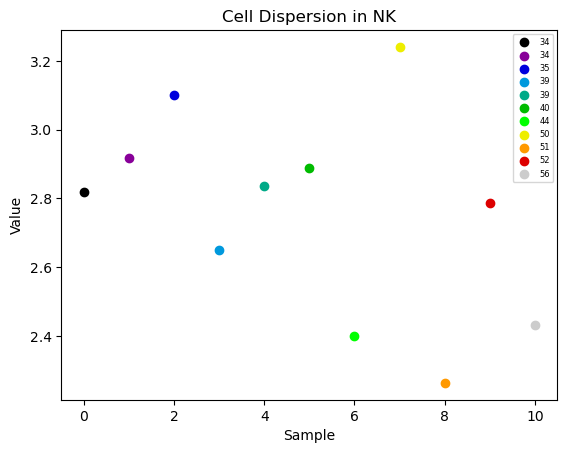

In [21]:
scatter_plot(mean_NK, "Cell Dispersion in NK", "NK")

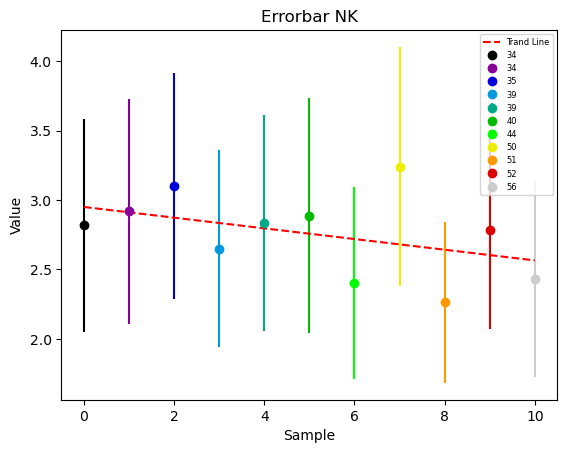

In [22]:
errorbar(mean_NK, "Errorbar NK", "NK")

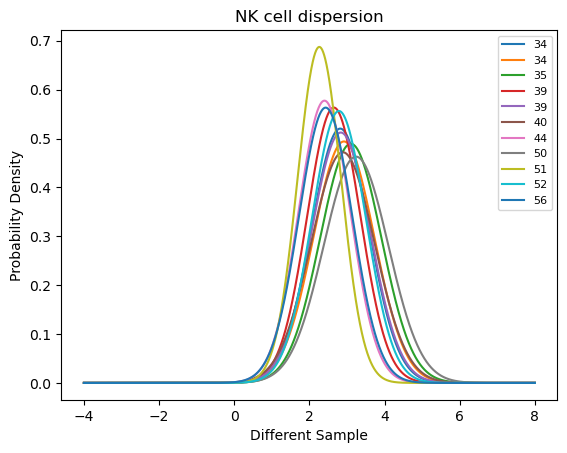

In [23]:
for i in range(0, len(mean_NK)):
    x = np.arange(-4, 8, 0.001)
    y = norm.pdf(x, mean_NK[i], std_NK[i])
    plt.plot(x,y)
    
# 添加圖例
plt.legend(age, fontsize = 8)
# 添加標題和軸標籤
plt.title("NK cell dispersion")
plt.xlabel('Different Sample')
plt.ylabel('Probability Density')


# 將圖形保存為PNG文件
plt.savefig('Result_picture/NK cell dispersion.png', dpi=900)

# CD4 T cell dispersion

In [24]:
dispersion_personal_CD4_T, mean_CD4_T, std_CD4_T = Excute_all(sorted_personal, "CD4 T")


100%|██████████| 11/11 [03:33<00:00, 19.41s/it]


In [25]:
count = 0
for i in sorted_personal:
    print(i)
    print("Age : ", age[count])
    print("Mean : ",mean_CD4_T[count])
    print("Standard Deviation : ", std_CD4_T[count], "\n")
    
    count += 1 

SAMN17379694
Age :  34
Mean :  2.8773004194132485
Standard Deviation :  0.8190162826217161 

SAMN17379698
Age :  34
Mean :  2.4100219035847985
Standard Deviation :  0.7218140971259507 

SAMN17379697
Age :  35
Mean :  2.8984155376180016
Standard Deviation :  0.8527450506544931 

SAMN17379693
Age :  39
Mean :  2.491709724934896
Standard Deviation :  0.7084686374280272 

SAMN17379591
Age :  39
Mean :  2.4481952740987145
Standard Deviation :  0.8046559930408251 

SAMN17379696
Age :  40
Mean :  2.5839789400227864
Standard Deviation :  0.7173864791105423 

SAMN17379695
Age :  44
Mean :  2.124013446146647
Standard Deviation :  0.5876571446042638 

SAMN17379671
Age :  50
Mean :  2.6898897804768875
Standard Deviation :  0.8124925500817128 

SAMN17379721
Age :  51
Mean :  2.1789082623291014
Standard Deviation :  0.6871734406292227 

SAMN17379592
Age :  52
Mean :  2.4919430332438153
Standard Deviation :  0.7268986424032109 

SAMN17379590
Age :  56
Mean :  2.377013485565185
Standard Deviation :  0

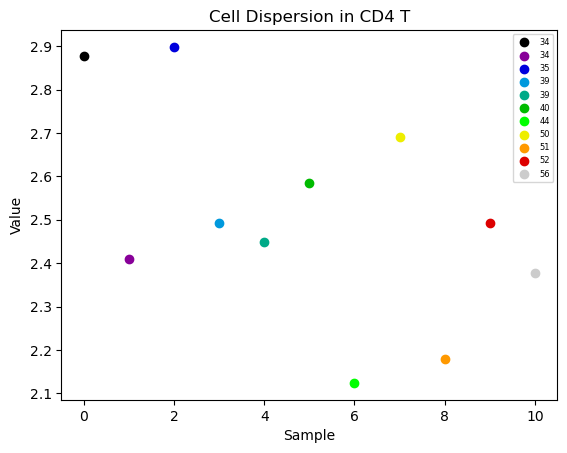

In [26]:
scatter_plot(mean_CD4_T, "Cell Dispersion in CD4 T", "CD4 T")

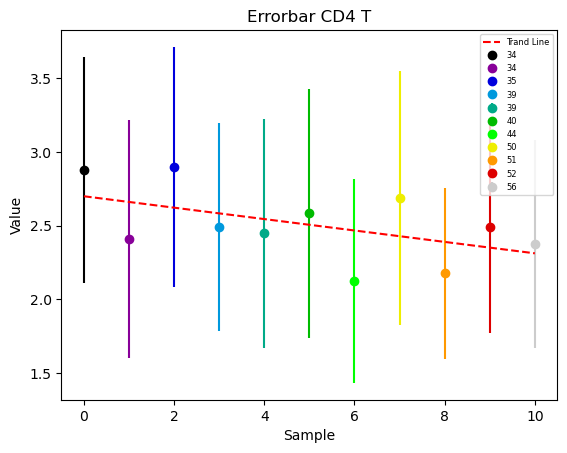

In [27]:
errorbar(mean_CD4_T, "Errorbar CD4 T", "CD4 T")

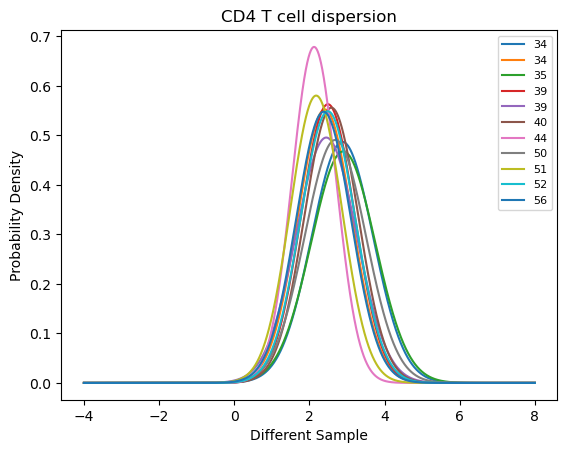

In [28]:
for i in range(0, len(mean_CD4_T)):
    x = np.arange(-4, 8, 0.001)
    y = norm.pdf(x, mean_CD4_T[i], std_CD4_T[i])
    plt.plot(x,y)
    
# 添加圖例
plt.legend(age, fontsize = 8)
# 添加標題和軸標籤
plt.title("CD4 T cell dispersion")
plt.xlabel('Different Sample')
plt.ylabel('Probability Density')

# 將圖形保存為PNG文件
plt.savefig('Result_picture/CD4T cell dispersion.png', dpi=900)

# CD8 T cell dispersion

In [29]:
dispersion_personal_CD8_T, mean_CD8_T, std_CD8_T = Excute_all(sorted_personal, "CD8 T")


100%|██████████| 11/11 [04:11<00:00, 22.85s/it]


In [30]:
count = 0
for i in sorted_personal:
    print(i)
    print("Age : ", age[count])
    print("Mean : ",mean_CD8_T[count])
    print("Standard Deviation : ", std_CD8_T[count], "\n")
    
    count += 1 

SAMN17379694
Age :  34
Mean :  2.6387988999430334
Standard Deviation :  0.7105150095594749 

SAMN17379698
Age :  34
Mean :  2.952572613525391
Standard Deviation :  0.8498248936980125 

SAMN17379697
Age :  35
Mean :  2.967855887552897
Standard Deviation :  0.8003136284105481 

SAMN17379693
Age :  39
Mean :  2.5335760248819987
Standard Deviation :  0.733792779055312 

SAMN17379591
Age :  39
Mean :  2.8260833811442057
Standard Deviation :  0.8277868360617457 

SAMN17379696
Age :  40
Mean :  2.731390854695638
Standard Deviation :  0.7140981652602982 

SAMN17379695
Age :  44
Mean :  2.348535905456543
Standard Deviation :  0.6993123315313569 

SAMN17379671
Age :  50
Mean :  2.722477911071777
Standard Deviation :  0.8389637482746767 

SAMN17379721
Age :  51
Mean :  2.3884508426920577
Standard Deviation :  0.7442738713064827 

SAMN17379592
Age :  52
Mean :  2.8095655888875326
Standard Deviation :  0.7548625935761827 

SAMN17379590
Age :  56
Mean :  2.5750819536336267
Standard Deviation :  0.75

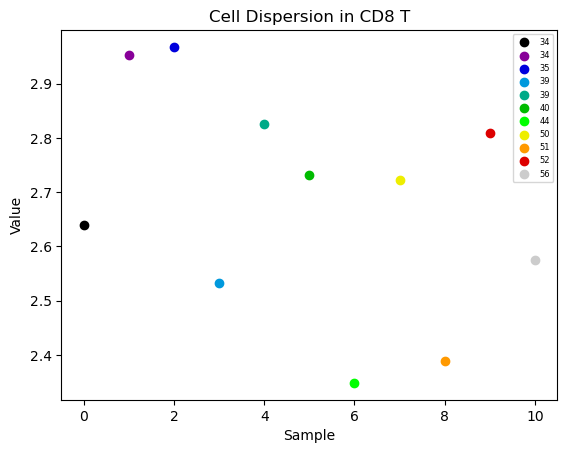

In [31]:
scatter_plot(mean_CD8_T, "Cell Dispersion in CD8 T", "CD8 T")

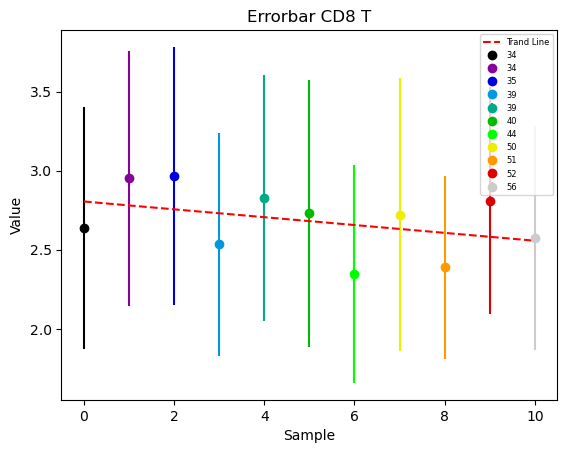

In [32]:
errorbar(mean_CD8_T, "Errorbar CD8 T", "CD8 T")

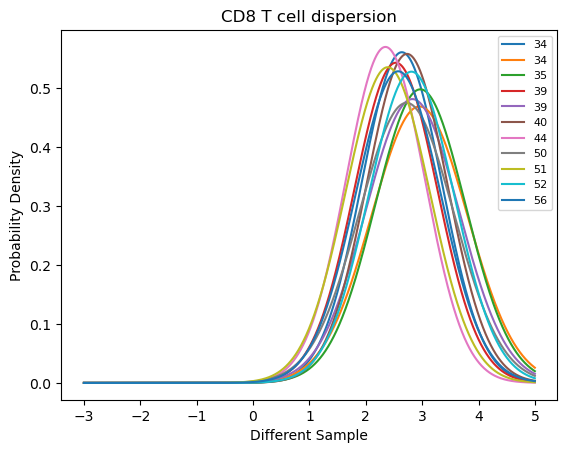

In [33]:
for i in range(0, len(mean_CD8_T)):
    x = np.arange(-3, 5, 0.001)
    y = norm.pdf(x, mean_CD8_T[i], std_CD8_T[i])
    plt.plot(x,y)
    
# 添加圖例
plt.legend(age, fontsize = 8)
# 添加標題和軸標籤
plt.title("CD8 T cell dispersion")
plt.xlabel('Different Sample')
plt.ylabel('Probability Density')

# 將圖形保存為PNG文件
plt.savefig('Result_picture/CD8T cell dispersion.png', dpi=900)

# DC cell dispersion

In [34]:
dispersion_personal_DC, mean_DC, std_DC = Excute_all(sorted_personal, "DC")


100%|██████████| 11/11 [00:32<00:00,  2.94s/it]


In [35]:
count = 0
for i in sorted_personal:
    print(i)
    print("Age : ", age[count])
    print("Mean : ",mean_DC[count])
    print("Standard Deviation : ", std_DC[count], "\n")
    
    count += 1 

SAMN17379694
Age :  34
Mean :  2.5296173202956935
Standard Deviation :  0.5518181152403392 

SAMN17379698
Age :  34
Mean :  2.9550475408581716
Standard Deviation :  0.4888218579867691 

SAMN17379697
Age :  35
Mean :  3.50627796560094
Standard Deviation :  0.6468115150257184 

SAMN17379693
Age :  39
Mean :  2.4220882603742075
Standard Deviation :  0.4345618582623928 

SAMN17379591
Age :  39
Mean :  4.108527243351591
Standard Deviation :  0.769373841610076 

SAMN17379696
Age :  40
Mean :  3.0479780197143556
Standard Deviation :  0.4447126697142833 

SAMN17379695
Age :  44
Mean :  2.4641354455256805
Standard Deviation :  0.45938421514192135 

SAMN17379671
Age :  50
Mean :  3.2890228598774347
Standard Deviation :  0.705957449505953 

SAMN17379721
Age :  51
Mean :  2.529730450837508
Standard Deviation :  0.3217566473151178 

SAMN17379592
Age :  52
Mean :  2.8297536848869878
Standard Deviation :  0.43646777133132086 

SAMN17379590
Age :  56
Mean :  3.391690295675527
Standard Deviation :  0.6

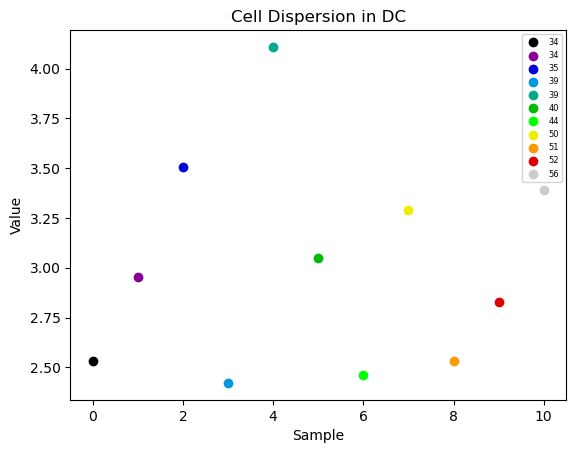

In [36]:
scatter_plot(mean_DC, "Cell Dispersion in DC", "DC")

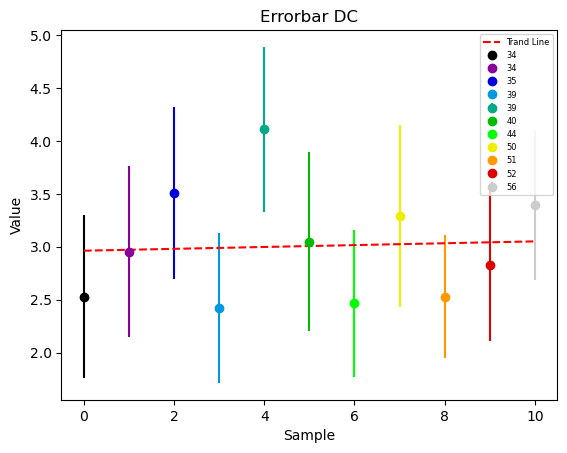

In [37]:
errorbar(mean_DC, "Errorbar DC", "DC")

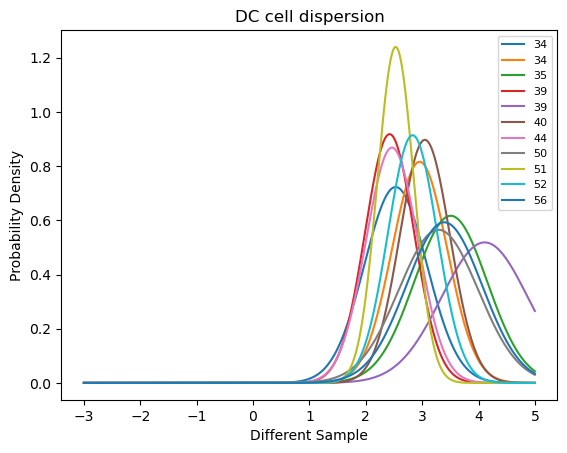

In [38]:
for i in range(0, len(mean_DC)):
    x = np.arange(-3, 5, 0.001)
    y = norm.pdf(x, mean_DC[i], std_DC[i])
    plt.plot(x,y)
    
# 添加圖例
plt.legend(age, fontsize = 8)
# 添加標題和軸標籤
plt.title("DC cell dispersion")
plt.xlabel('Different Sample')
plt.ylabel('Probability Density')

# 將圖形保存為PNG文件
plt.savefig('Result_picture/DC cell dispersion.png', dpi=900)

# Monocyte cell dispersion

In [39]:
dispersion_personal_mono, mean_mono, std_mono = Excute_all(sorted_personal, "Mono")


100%|██████████| 11/11 [04:50<00:00, 26.43s/it]


In [40]:
count = 0
for i in sorted_personal:
    print(i)
    print("Age : ", age[count])
    print("Mean : ",mean_mono[count])
    print("Standard Deviation : ", std_mono[count], "\n")
    
    count += 1 

SAMN17379694
Age :  34
Mean :  4.069036409505208
Standard Deviation :  0.9184770727414107 

SAMN17379698
Age :  34
Mean :  4.7853588163248695
Standard Deviation :  0.9357468840077056 

SAMN17379697
Age :  35
Mean :  3.8230104911295575
Standard Deviation :  0.9113652317318567 

SAMN17379693
Age :  39
Mean :  4.198258073730469
Standard Deviation :  0.8920905776379755 

SAMN17379591
Age :  39
Mean :  4.373054478759766
Standard Deviation :  0.9376783688827863 

SAMN17379696
Age :  40
Mean :  4.648797529093424
Standard Deviation :  0.8732221882939497 

SAMN17379695
Age :  44
Mean :  3.5463664145914717
Standard Deviation :  0.9031809924734187 

SAMN17379671
Age :  50
Mean :  3.9922931257120773
Standard Deviation :  0.8485970593341688 

SAMN17379721
Age :  51
Mean :  3.5610629321289062
Standard Deviation :  0.8610961425001163 

SAMN17379592
Age :  52
Mean :  4.1629546396891275
Standard Deviation :  0.8491199207422944 

SAMN17379590
Age :  56
Mean :  3.34971690633138
Standard Deviation :  0.80

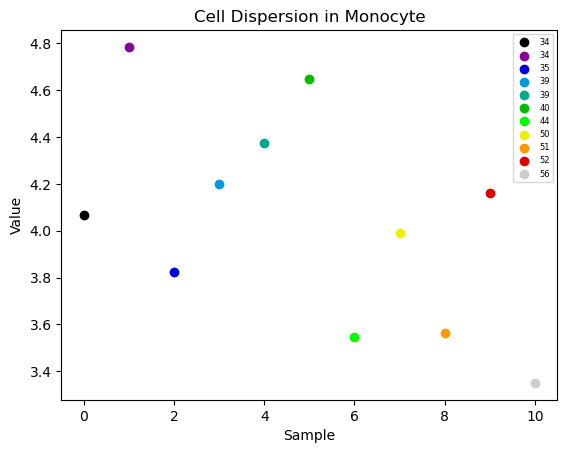

In [41]:
scatter_plot(mean_mono, "Cell Dispersion in Monocyte", "Monocyte")

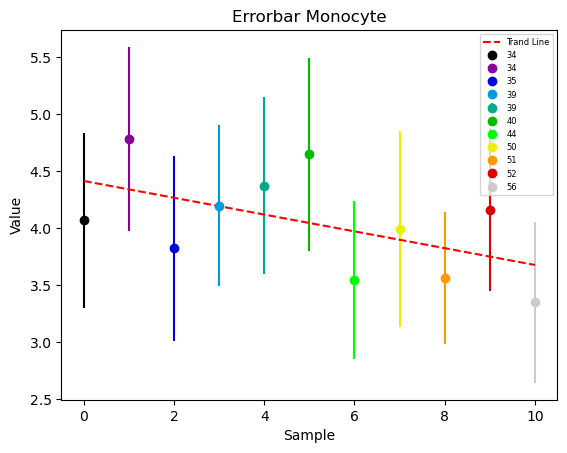

In [42]:
errorbar(mean_mono, "Errorbar Monocyte", "Monocyte")

  0%|          | 0/11 [16:34<?, ?it/s]


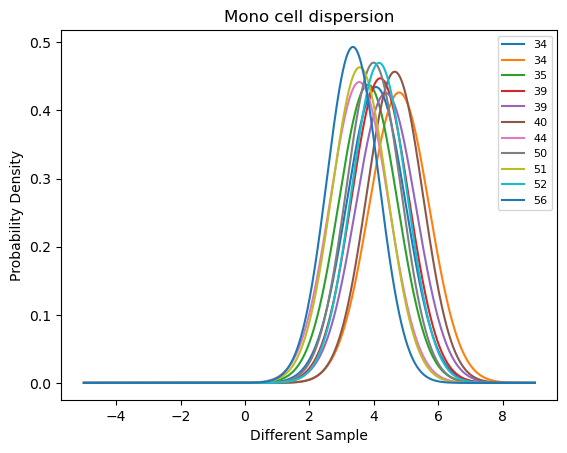

In [43]:
for i in range(0, len(mean_mono)):
    x = np.arange(-5, 9, 0.001)
    y = norm.pdf(x, mean_mono[i], std_mono[i])
    plt.plot(x,y)
    
# 添加圖例
plt.legend(age, fontsize = 8)
# 添加標題和軸標籤
plt.title("Mono cell dispersion")
plt.xlabel('Different Sample')
plt.ylabel('Probability Density')

# 將圖形保存為PNG文件
plt.savefig('Result_picture/Mono cell dispersion.png', dpi=900)

# B cell dispersion

In [44]:
dispersion_personal_B, mean_B, std_B = Excute_all(sorted_personal, "B")

100%|██████████| 11/11 [01:34<00:00,  8.55s/it]


In [45]:
count = 0
for i in sorted_personal:
    print(i)
    print("Age : ", age[count])
    print("Mean : ",mean_B[count])
    print("Standard Deviation : ", std_B[count], "\n")
    
    count += 1 

SAMN17379694
Age :  34
Mean :  2.7110399948120123
Standard Deviation :  0.6724265516208322 

SAMN17379698
Age :  34
Mean :  2.6162304494222006
Standard Deviation :  0.7432283785460272 

SAMN17379697
Age :  35
Mean :  3.0025388188680013
Standard Deviation :  0.6831381840583342 

SAMN17379693
Age :  39
Mean :  2.788696985778809
Standard Deviation :  0.6786769273574123 

SAMN17379591
Age :  39
Mean :  2.7170177804565427
Standard Deviation :  0.555057022407169 

SAMN17379696
Age :  40
Mean :  2.586041315409342
Standard Deviation :  0.6115998809404454 

SAMN17379695
Age :  44
Mean :  2.2486254078165695
Standard Deviation :  0.5896412659853975 

SAMN17379671
Age :  50
Mean :  3.006285831705729
Standard Deviation :  0.7365318480651745 

SAMN17379721
Age :  51
Mean :  2.4922152194213867
Standard Deviation :  0.5967701288412625 

SAMN17379592
Age :  52
Mean :  2.7417308289591475
Standard Deviation :  0.7426082479592738 

SAMN17379590
Age :  56
Mean :  2.4686295432535807
Standard Deviation :  0.

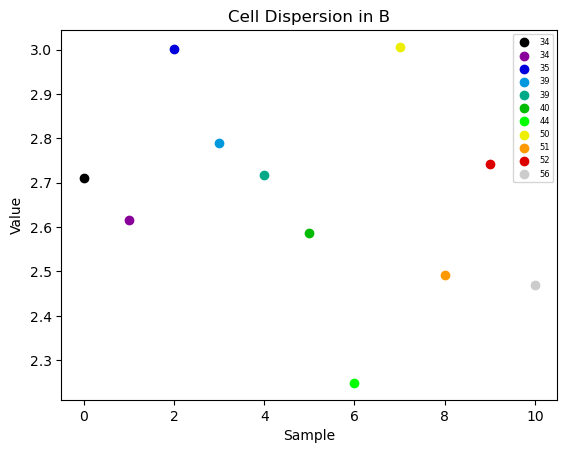

In [46]:
scatter_plot(mean_B, "Cell Dispersion in B", "B")

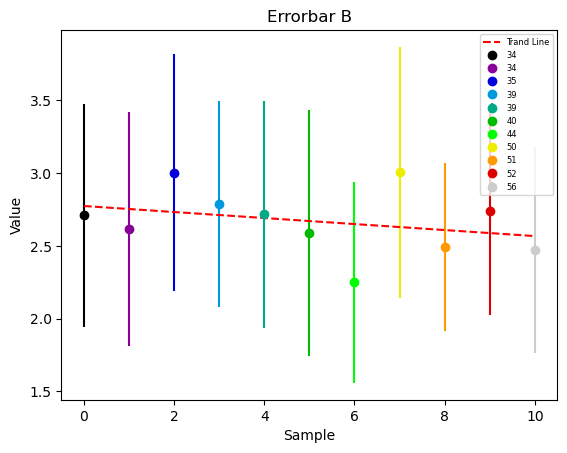

In [47]:
errorbar(mean_B, "Errorbar B", "B")

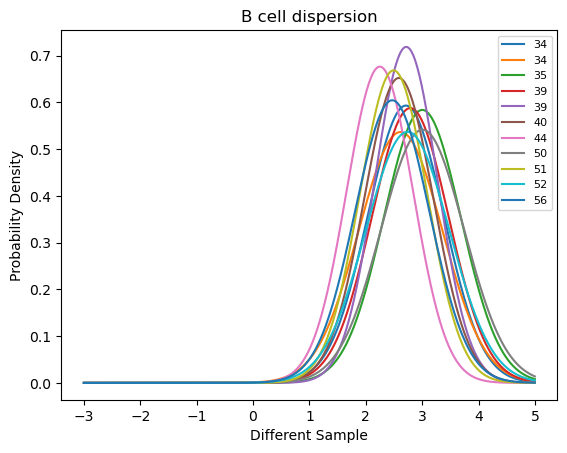

In [48]:
for i in range(0, len(mean_B)):
    x = np.arange(-3, 5, 0.001)
    y = norm.pdf(x, mean_B[i], std_B[i])
    plt.plot(x,y)
    
# 添加圖例
plt.legend(age, fontsize = 8)
# 添加標題和軸標籤
plt.title("B cell dispersion")
plt.xlabel('Different Sample')
plt.ylabel('Probability Density')

# 將圖形保存為PNG文件
plt.savefig('Result_picture/B cell dispersion.png', dpi=900)

# other T cell dispersion

In [49]:
dispersion_personal_other_T, mean_other_T, std_other_T = Excute_all(sorted_personal, "other T")

100%|██████████| 11/11 [00:49<00:00,  4.52s/it]


In [50]:
count = 0
for i in sorted_personal:
    print(i)
    print("Age : ", age[count])
    print("Mean : ",mean_other_T[count])
    print("Standard Deviation : ", std_other_T[count], "\n")
    
    count += 1 

SAMN17379694
Age :  34
Mean :  2.500112812906901
Standard Deviation :  0.6464884947248173 

SAMN17379698
Age :  34
Mean :  3.7487910885620117
Standard Deviation :  0.8470706054583522 

SAMN17379697
Age :  35
Mean :  3.186579219970703
Standard Deviation :  0.9034953868134694 

SAMN17379693
Age :  39
Mean :  2.471147854614258
Standard Deviation :  0.6452051968306767 

SAMN17379591
Age :  39
Mean :  1.8814527247111001
Standard Deviation :  0.4198412547447961 

SAMN17379696
Age :  40
Mean :  2.881349632975261
Standard Deviation :  0.7302073488856624 

SAMN17379695
Age :  44
Mean :  2.008329409128825
Standard Deviation :  0.5892034320380662 

SAMN17379671
Age :  50
Mean :  3.226736283874512
Standard Deviation :  0.8810963882889727 

SAMN17379721
Age :  51
Mean :  1.9225374014282226
Standard Deviation :  0.4034367397495279 

SAMN17379592
Age :  52
Mean :  3.099946333312988
Standard Deviation :  0.7280607487705385 

SAMN17379590
Age :  56
Mean :  2.4407367622884113
Standard Deviation :  0.733

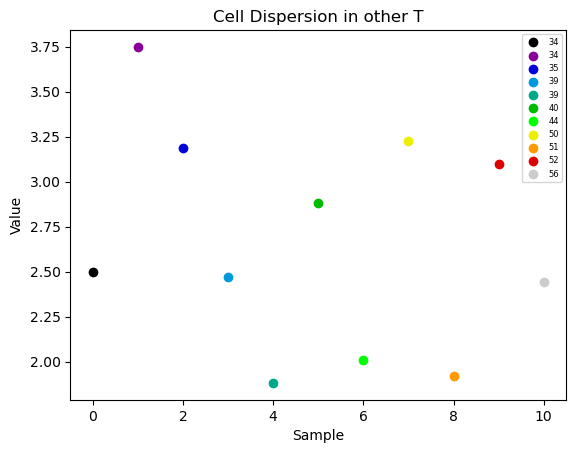

In [51]:
scatter_plot(mean_other_T, "Cell Dispersion in other T", "other T")

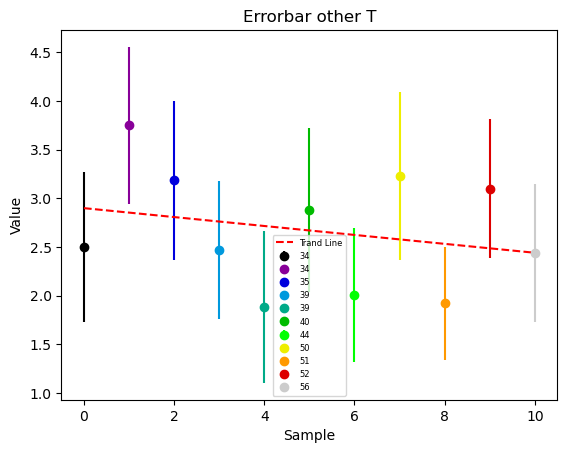

In [52]:
errorbar(mean_other_T, "Errorbar other T", "other T")

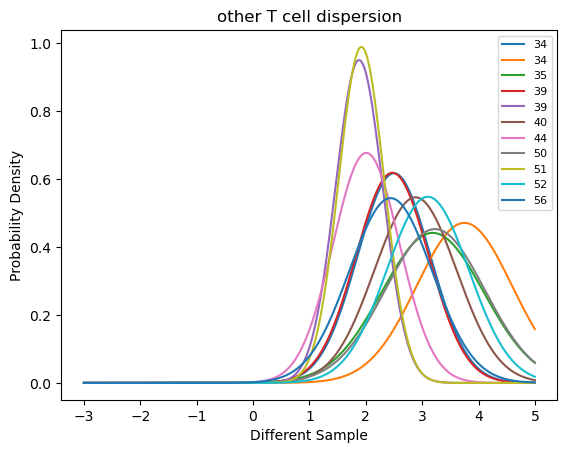

In [53]:
for i in range(0, len(mean_other_T)):
    x = np.arange(-3, 5, 0.001)
    y = norm.pdf(x, mean_other_T[i], std_other_T[i])
    plt.plot(x,y)
    
# 添加圖例
plt.legend(age, fontsize = 8)
# 添加標題和軸標籤
plt.title("other T cell dispersion")
plt.xlabel('Different Sample')
plt.ylabel('Probability Density')

# 將圖形保存為PNG文件
plt.savefig('Result_picture/other T cell dispersion.png', dpi=900)

# other cell dispersion

In [54]:
dispersion_personal_other, mean_other, std_other = Excute_all(sorted_personal, "other")

100%|██████████| 11/11 [00:08<00:00,  1.29it/s]


In [55]:
count = 0
for i in sorted_personal:
    print(i)
    print("Age : ", age[count])
    print("Mean : ",mean_other[count])
    print("Standard Deviation : ", std_other[count], "\n")
    
    count += 1 

SAMN17379694
Age :  34
Mean :  0.42196524756749465
Standard Deviation :  0.10918337865090984 

SAMN17379698
Age :  34
Mean :  1.3257146608511607
Standard Deviation :  0.3959225593252609 

SAMN17379697
Age :  35
Mean :  0.5279604625066122
Standard Deviation :  0.4765569608424007 

SAMN17379693
Age :  39
Mean :  0.7758470620950063
Standard Deviation :  0.34966012814287106 

SAMN17379591
Age :  39
Mean :  0.606671037197113
Standard Deviation :  0.23907149815646914 

SAMN17379696
Age :  40
Mean :  0.8921561411539713
Standard Deviation :  1.0099146339512632 

SAMN17379695
Age :  44
Mean :  0.8916975121339162
Standard Deviation :  0.7448994323979087 

SAMN17379671
Age :  50
Mean :  0.6082118637879689
Standard Deviation :  0.6296890923676854 

SAMN17379721
Age :  51
Mean :  0.976029410123825
Standard Deviation :  0.45115166160296505 

SAMN17379592
Age :  52
Mean :  0.271911591943105
Standard Deviation :  0.043960628641242144 

SAMN17379590
Age :  56
Mean :  0.2829691197077433
Standard Deviati

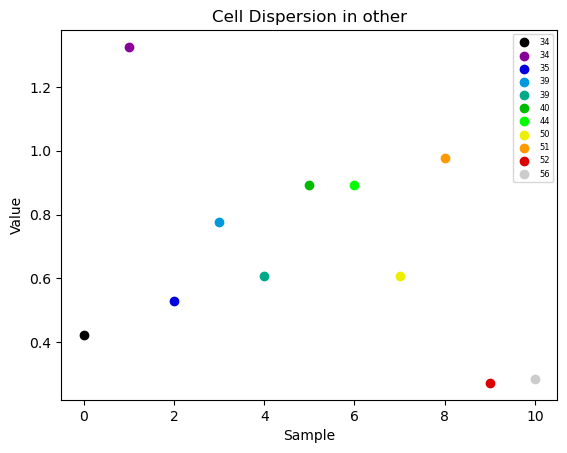

In [56]:
scatter_plot(mean_other, "Cell Dispersion in other", "other")

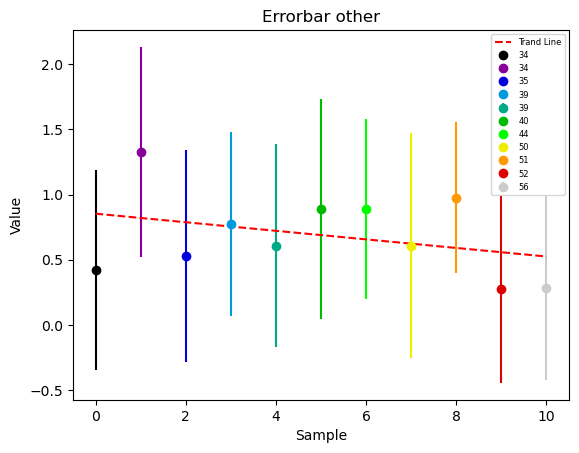

In [57]:
errorbar(mean_other, "Errorbar other", "other")

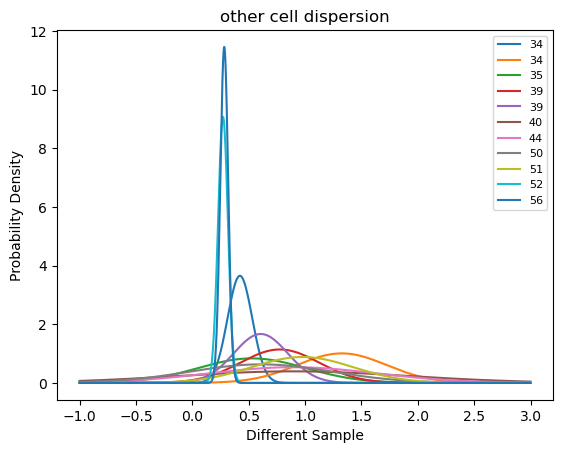

In [58]:
for i in range(0, len(mean_other)):
    x = np.arange(-1, 3, 0.001)
    y = norm.pdf(x, mean_other[i], std_other[i])
    plt.plot(x,y)
    
# 添加圖例
plt.legend(age, fontsize = 8)
# 添加標題和軸標籤
plt.title("other cell dispersion")
plt.xlabel('Different Sample')
plt.ylabel('Probability Density')

# 將圖形保存為PNG文件
plt.savefig('Result_picture/other cell dispersion.png', dpi=900)

In [59]:
import csv
with open('mean_and_stdev.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    # 寫入列名
    writer.writerow([''] + ['age', 'mean_NK', 'mean_CD4_T', 'mean_CD8_T', 'mean_DC', 'mean_mono', 'mean_B', 'mean_other_T', 'mean_other', 'std_NK', 'std_CD4_T', 'std_CD8_T', 'std_DC', 'std_mono', 'std_B', 'std_other_T', 'std_other'])
    
    # 寫入數據
    for sample, Age, Mean_NK, Mean_CD4_T, Mean_CD8_T, Mean_DC, Mean_mono, Mean_B, Mean_other_T, Mean_other, Std_NK, Std_CD4_T, Std_CD8_T, Std_DC, Std_mono, Std_B, Std_other_T, Std_other in zip(sorted_personal, age, mean_NK, mean_CD4_T, mean_CD8_T, mean_DC, mean_mono, mean_B, mean_other_T, mean_other, std_NK, std_CD4_T, std_CD8_T, std_DC, std_mono, std_B, std_other_T, std_other):
        writer.writerow([sample] + [Age, Mean_NK, Mean_CD4_T, Mean_CD8_T, Mean_DC, Mean_mono, Mean_B, Mean_other_T, Mean_other, Std_NK, Std_CD4_T, Std_CD8_T, Std_DC, Std_mono, Std_B, Std_other_T, Std_other])

In [ ]:
"""# 創建一個子圖
fig, ax = plt.subplots()

for i in range(0,len(dispersion_personal)):
    ax.hist(dispersion_personal[i], alpha=0.5,bins = 30, density=True)
    """

In [ ]:
# 繪製直方圖
#plt.hist(dispersion_NK, bins=30, density=True)
#plt.xlabel('Dispersion')
#plt.ylabel('Probability Density')

In [ ]:
"""# 取得1000次抽樣的離散程度
dispersion_NK_1 = []
for i in range(0,1000):
    # 取得sampling的dataframe
    cell_dispersion_NK_1 = renew_sampling_list(NK_1)
    # 計算 cell * cell distance
    distance_matrix_NK_1 = create_distance_matrix(cell_dispersion_NK_1)
    # 取得此次抽樣的dispersion
    dispersion_NK_1.append(calculate_dispersion(distance_matrix_NK_1))"""